In [8]:
import numpy as np
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt

In [9]:
from sklearn.model_selection import train_test_split
data_train = pd.read_csv('/content/fashion-mnist_train.csv')
X_full = data_train.iloc[:,1:]
y_full = data_train.iloc[:,:1]
x_train, x_test, y_train, y_test = train_test_split(X_full, y_full, test_size
= 0.3)
x_train = x_train.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
x_test = x_test.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
y_train = y_train.values.astype('int')
y_test = y_test.values.astype('int')
print('Training', x_train.shape, x_train.max())
print('Testing', x_test.shape, x_test.max())

Training (42000, 28, 28, 1) 1.0
Testing (18000, 28, 28, 1) 1.0


In [10]:
def gen_random_batch(in_groups, batch_halfsize = 8):
  out_img_a, out_img_b, out_score = [], [], []
  all_groups = list(range(len(in_groups)))
  for match_group in [True, False]:
    group_idx = np.random.choice(all_groups, size = batch_halfsize)
    out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
    if match_group:
      b_group_idx = group_idx
      out_score += [1]*batch_halfsize
    else:
      # anything but the same group
      non_group_idx = [np.random.choice([i for i in all_groups if i!=c_idx]) for c_idx in group_idx]
      b_group_idx = non_group_idx
      out_score += [0]*batch_halfsize

    out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]

  return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

In [11]:
# reorganize by groups
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [4200, 4207, 4148, 4222, 4248, 4172, 4150, 4211, 4241, 4201]
test groups: [1800, 1793, 1852, 1778, 1752, 1828, 1850, 1789, 1759, 1799]


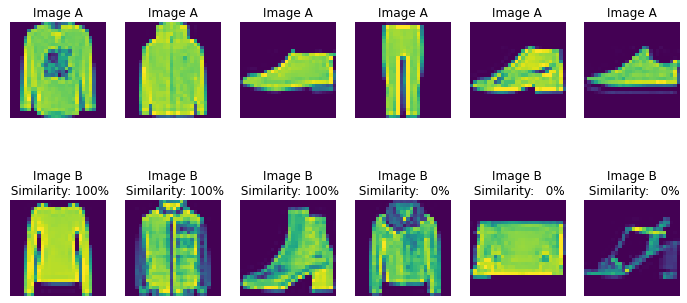

In [12]:
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
  ax1.imshow(c_a[:,:,0])
  ax1.set_title('Image A')
  ax1.axis('off')
  ax2.imshow(c_b[:,:,0])
  ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
  ax2.axis('off')


In [13]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout, SpatialDropout2D, Concatenate, AveragePooling2D
from keras.regularizers import l2
from keras.initializers import he_normal, random_normal

In [14]:
# Hyperparameters
num_classes = 10
l = 12
num_filter = 24
compression = 0.5
dropout_rate = 0.2
wt_decay = 0.001

In [15]:
def add_denseblock(input, num_filter = 12, dropout_rate = 0.2):
  global compression
  temp = input
  for _ in range(l):
    BatchNorm = BatchNormalization()(temp)
    relu = Activation('relu')(BatchNorm)
    Conv2D_3_3 = Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same', kernel_regularizer=l2(wt_decay) , kernel_initializer=(random_normal(stddev=np.sqrt(2.0/(9*int(num_filter))))))(relu)
    Conv2D_3_3 = SpatialDropout2D(dropout_rate)(Conv2D_3_3)
    concat = Concatenate(axis=-1)([temp,Conv2D_3_3])

    temp = concat

  return temp

In [16]:
def add_transition(input, num_filter = 12, dropout_rate = 0.2):
  global compression
  BatchNorm = BatchNormalization()(input)
  relu = Activation('relu')(BatchNorm)
  Conv2D_BottleNeck = Conv2D(int(int(input.shape[-1])*compression), (1,1), use_bias=False ,padding='same',kernel_regularizer=l2(wt_decay) , kernel_initializer=(random_normal(stddev=np.sqrt(2.0/(9*int(num_filter*compression))))))(relu)
  Conv2D_BottleNeck = SpatialDropout2D(dropout_rate)(Conv2D_BottleNeck)
  avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)

  return avg

In [17]:
def output_layer(input):
  global compression
  BatchNorm = BatchNormalization()(input)
  relu = Activation('relu')(BatchNorm)
  AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
  flat = Flatten()(AvgPooling)
  output = Dense(num_classes, activation='softmax', kernel_regularizer=l2(wt_decay))(flat)

  return output

In [18]:
img_in = Input(shape = x_train.shape[1:], name = 'FeatureNet_ImageInput')
First_Conv2D = Conv2D(int(num_filter), (3,3), use_bias=False , padding='same', kernel_regularizer=l2(wt_decay), kernel_initializer=(random_normal(stddev=np.sqrt(2.0/(9*num_filter)))))(img_in)

First_Block = add_denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filter, dropout_rate)

Second_Block = add_denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)

Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

Last_Block = add_denseblock(Third_Transition,  num_filter, dropout_rate)
Last_Block = output_layer(Last_Block)

feature_model = Model(inputs = [img_in], outputs = [Last_Block], name = 'FeatureGenerationModel')
feature_model.summary()

Model: "FeatureGenerationModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 FeatureNet_ImageInput (InputLa  [(None, 28, 28, 1)]  0          []                               
 yer)                                                                                             
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 24)   216         ['FeatureNet_ImageInput[0][0]']  
                                                                                                  
 batch_normalization (BatchNorm  (None, 28, 28, 24)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                             

In [19]:
from keras.layers import concatenate
img_a_in = Input(shape = x_train.shape[1:], name = 'ImageA_Input')
img_b_in = Input(shape = x_train.shape[1:], name = 'ImageB_Input')
img_a_feat = feature_model(img_a_in)
img_b_feat = feature_model(img_b_in)
combined_features = concatenate([img_a_feat, img_b_feat], name = 'merge_features')
combined_features = Dense(16, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation = 'sigmoid')(combined_features)
similarity_model = Model(inputs = [img_a_in, img_b_in], outputs = [combined_features], name = 'Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 FeatureGenerationModel (Functi  (None, 10)          906610      ['ImageA_Input[0][0]',           
 onal)                                                            'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 20)           0           ['FeatureGeneratio

In [20]:
# setup the optimization process
similarity_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['mae'])

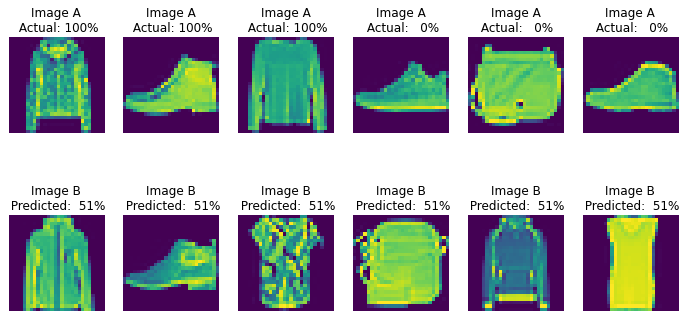

In [21]:
def show_model_output(nb_examples = 3):
  pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
  pred_sim = similarity_model.predict([pv_a, pv_b])
  fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
  for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
    ax1.imshow(c_a[:,:,0])
    ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
    ax1.axis('off')
    ax2.imshow(c_b[:,:,0])
    ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
    ax2.axis('off')
  return fig
# a completely untrained model
_ = show_model_output()

In [22]:
%tensorflow_version 2.x
import tensorflow as tf

In [23]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [24]:
# make a generator out of the data
def siam_gen(in_groups, batch_size = 32):
  while True:
    pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
    yield [pv_a, pv_b], pv_sim
# we want a constant validation group to have a frame of reference for model performance
valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit_generator(siam_gen(train_groups), steps_per_epoch = 500, validation_data=([valid_a, valid_b], valid_sim), epochs = 10, verbose = True)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


500/500 [==============================] - 73s 110ms/step - loss: 4.0739 - mae: 0.4806 - val_loss: 1.3785 - val_mae: 0.3956
Epoch 2/10
500/500 [==============================] - 52s 105ms/step - loss: 0.9185 - mae: 0.3525 - val_loss: 0.6320 - val_mae: 0.2897
Epoch 3/10
500/500 [==============================] - 54s 108ms/step - loss: 0.5945 - mae: 0.2941 - val_loss: 0.5321 - val_mae: 0.2729
Epoch 4/10
500/500 [==============================] - 53s 105ms/step - loss: 0.5294 - mae: 0.2733 - val_loss: 0.4867 - val_mae: 0.2598
Epoch 5/10
500/500 [==============================] - 53s 106ms/step - loss: 0.5053 - mae: 0.2627 - val_loss: 0.4895 - val_mae: 0.2553
Epoch 6/10
500/500 [==============================] - 53s 106ms/step - loss: 0.5024 - mae: 0.2626 - val_loss: 0.4714 - val_mae: 0.2463
Epoch 7/10
500/500 [==============================] - 53s 106ms/step - loss: 0.4929 - mae: 0.2531 - val_loss: 0.4719 - val_mae: 0.2376
Epoch 8/10
500/500 [==============================] - 54s 108ms/st

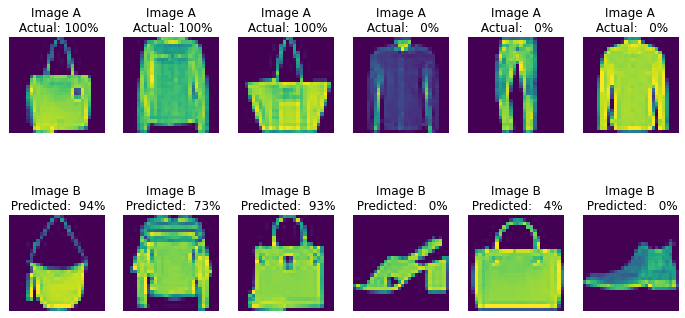

In [25]:
_ = show_model_output()

In [26]:
t_shirt_vec = np.stack([train_groups[0][0]]*x_test.shape[0],0)
t_shirt_score = similarity_model.predict([t_shirt_vec, x_test], verbose = True, batch_size = 128)
ankle_boot_vec = np.stack([train_groups[-1][0]]*x_test.shape[0],0)
ankle_boot_score = similarity_model.predict([ankle_boot_vec, x_test], verbose = True, batch_size = 128)

141/141 [==============================] - 11s 82ms/step


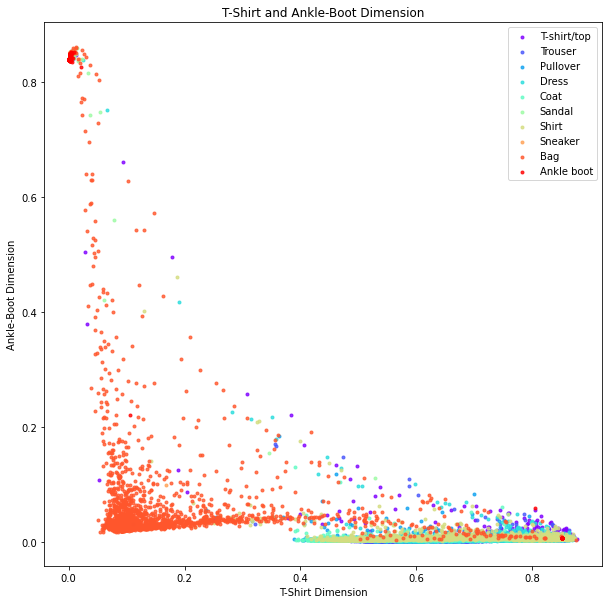

In [27]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress', 'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
  plt.scatter(t_shirt_score[np.where(y_test == c_group), 0], ankle_boot_score[np.where(y_test == c_group), 0], marker='.', color=c_color, linewidth='1', alpha=0.8, label=c_label)
plt.xlabel('T-Shirt Dimension')
plt.ylabel('Ankle-Boot Dimension')
plt.title('T-Shirt and Ankle-Boot Dimension')
plt.legend(loc='best')
plt.savefig('tshirt-boot-dist.png')
plt.show(block=False)

In [28]:
x_test_features = feature_model.predict(x_test, verbose = True, batch_size=128)

141/141 [==============================] - 6s 40ms/step


In [29]:
%%time
from sklearn.manifold import TSNE
tsne_obj = TSNE(n_components=2, init='pca', random_state=101, method='barnes_hut', n_iter=500, verbose=2)
tsne_features = tsne_obj.fit_transform(x_test_features)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 18000 samples in 0.025s...
[t-SNE] Computed neighbors for 18000 samples in 0.569s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18000
[t-SNE] Computed conditional probabilities for sample 2000 / 18000
[t-SNE] Computed conditional probabilities for sample 3000 / 18000
[t-SNE] Computed conditional probabilities for sample 4000 / 18000
[t-SNE] Computed conditional probabilities for sample 5000 / 18000
[t-SNE] Computed conditional probabilities for sample 6000 / 18000
[t-SNE] Computed conditional probabilities for sample 7000 / 18000
[t-SNE] Computed conditional probabilities for sample 8000 / 18000
[t-SNE] Computed conditional probabilities for sample 9000 / 18000
[t-SNE] Computed conditional probabilities for sample 10000 / 18000
[t-SNE] Computed conditional probabilities for sample 11000 / 18000
[t-SNE] Computed conditional probabilities for sample 12000 / 18000
[t-SNE] Computed conditional probabilities for sam

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] Iteration 50: error = 84.5429459, gradient norm = 0.0029848 (50 iterations in 7.289s)
[t-SNE] Iteration 100: error = 78.5540695, gradient norm = 0.0019771 (50 iterations in 6.798s)
[t-SNE] Iteration 150: error = 76.0999374, gradient norm = 0.0012888 (50 iterations in 6.554s)
[t-SNE] Iteration 200: error = 74.7576370, gradient norm = 0.0009648 (50 iterations in 6.492s)
[t-SNE] Iteration 250: error = 73.8993912, gradient norm = 0.0007547 (50 iterations in 6.454s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.899391
[t-SNE] Iteration 300: error = 3.0292449, gradient norm = 0.0012057 (50 iterations in 6.536s)
[t-SNE] Iteration 350: error = 2.4660513, gradient norm = 0.0006724 (50 iterations in 6.472s)
[t-SNE] Iteration 400: error = 2.1061411, gradient norm = 0.0004318 (50 iterations in 6.548s)
[t-SNE] Iteration 450: error = 1.8735287, gradient norm = 0.0003048 (50 iterations in 6.481s)
[t-SNE] Iteration 500: error = 1.7130532, gradient norm = 0.0002305 (50 

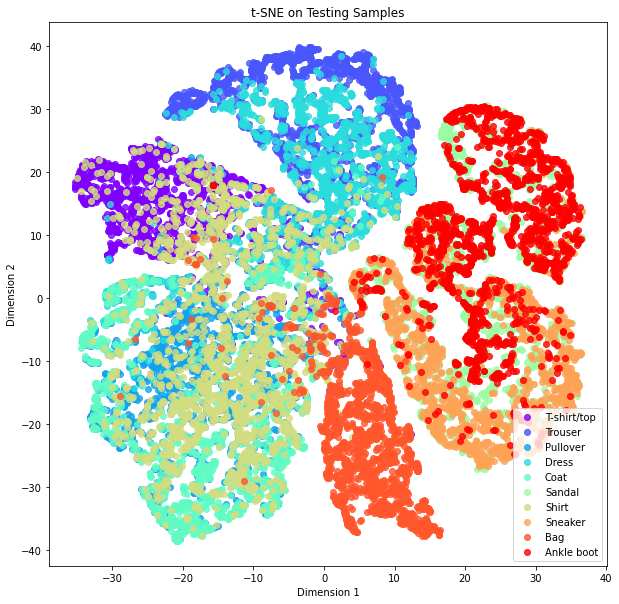

In [30]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress', 'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
  plt.scatter(tsne_features[np.where(y_test == c_group), 0], tsne_features[np.where(y_test == c_group), 1], marker='o', color=c_color, linewidth='1', alpha=0.8, label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)